In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import os
import scipy
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as DL
from torch.utils.data import TensorDataset as TData
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split as tts
import pickle

from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [ ]:
root = '/content/drive/MyDrive/LHNTData'

In [ ]:
# Base folder containing the files
# right_session_folder = os.path.join(root, "alan_f_right/session_1")

# Initialize a dictionary to store the loaded signals
right_eeg_data = {}

# Iterate through files labeled in increments of two
for j in range(1, 4):
  right_session_folder = os.path.join(root, f"morgan_dye_Session{j}")
  for i in range(2, 21, 2):  # Adjust the range as needed

      file_path = os.path.join(right_session_folder, f"right_16.pkl")

      # Check if the file exists
      if os.path.exists(file_path):
          with open(file_path, "rb") as file:
              data = pickle.load(file)
              right_eeg_data[f"right_{j}_{i}"] = data  # Store the data with the corresponding label
      else:
          print(f"File not found: {file_path}")
          break  # Stop if the file sequence ends

left_eeg_data = {}

for j in range(1, 4):
  left_session_folder = os.path.join(root, f"morgan_dye_Session{j}")
  # Iterate through files labeled in increments of two
  for i in range(1, 21, 2):  # Adjust the range as needed
      file_path = os.path.join(left_session_folder, f"left_19.pkl")

      # Check if the file exists
      if os.path.exists(file_path):
          with open(file_path, "rb") as file:
              data = pickle.load(file)
              left_eeg_data[f"left_{j}_{i}"] = data  # Store the data with the corresponding label
      else:
          print(f"File not found: {file_path}")
          break  # Stop if the file sequence ends



right_signal_data = {label: signal[0] for label, signal in right_eeg_data.items()}
right_metadata = {label: signal[1] for label, signal in right_eeg_data.items()}

left_signal_data = {label: signal[0] for label, signal in left_eeg_data.items()}
metadata = {label: signal[1] for label, signal in left_eeg_data.items()}



In [ ]:
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler

def baseline_correction(signal):
    """
    Removes baseline offset by subtracting the mean of each channel.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).

    Returns:
        np.ndarray: Baseline-corrected signal.
    """
    return signal - np.mean(signal, axis=1, keepdims=True)


def bandpass_filter(signal, lowcut=13, highcut=30, fs=125, order=4):
    """
    Band-pass filters the signal for the specified frequency range.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).
        lowcut (float): Lower cutoff frequency (Hz).
        highcut (float): Upper cutoff frequency (Hz).
        fs (float): Sampling rate (Hz).
        order (int): Order of the filter.

    Returns:
        np.ndarray: Band-pass filtered signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal, axis=1)

def normalize_signal(signal):
    """
    Normalizes the signal for each channel (z-score normalization).

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).

    Returns:
        np.ndarray: Normalized signal.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(signal.T).T  # Transpose to normalize each channel

def preprocess_eeg(signal, fs=256):
    """
    Preprocess EEG signal with baseline correction, band-pass filtering, and normalization.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).
        fs (float): Sampling rate (Hz).

    Returns:
        np.ndarray: Preprocessed EEG signal.
    """
    # Step 1: Baseline Correction
    signal_corrected = baseline_correction(signal)

    # Step 2: Band-Pass Filter (Beta Frequencies)
    signal_filtered = bandpass_filter(signal_corrected, lowcut=4, highcut=40, fs=fs)

    # Step 3: Normalization
    signal_normalized = normalize_signal(signal_filtered)

    return signal_normalized

def sliding_window_augmentation(data, labels, window_size=125, stride=80):
    """
    Apply sliding window to already EMD-processed data

    Args:
    data: numpy array of shape (n_samples, n_channels*n_imfs, time_steps)
    labels: numpy array of shape (n_samples,)
    window_size: size of sliding window
    stride: step size for sliding window

    Returns:
    augmented_data, augmented_labels
    """
    n_samples, n_features, time_steps = data.shape
    n_windows = (time_steps - window_size) // stride + 1

    augmented_data = np.zeros((n_samples * n_windows, n_features, window_size))
    augmented_labels = np.zeros(n_samples * n_windows, dtype=labels.dtype)

    idx = 0
    for i in range(n_samples):
        for j in range(n_windows):
            start = j * stride
            end = start + window_size
            augmented_data[idx] = data[i, :, start:end]
            augmented_labels[idx] = labels[i]
            idx += 1

    return augmented_data, augmented_labels

In [ ]:
# Preprocess each signal in the dictionary
right_preprocessed_signals = {label: preprocess_eeg(signal, fs=256) for label, signal in right_signal_data.items()}

# Inspect the shapes of the processed signals
for label, signal in right_preprocessed_signals.items():
    print(f"{label}: RIGHT Processed Signal Shape = {signal.shape}")


# Preprocess each signal in the dictionary
left_preprocessed_signals = {label: preprocess_eeg(signal, fs=256) for label, signal in left_signal_data.items()}

# Inspect the shapes of the processed signals
for label, signal in left_preprocessed_signals.items():
    print(f"{label}: LEFT Processed Signal Shape = {signal.shape}")



right_1_2: RIGHT Processed Signal Shape = (16, 875)
right_1_4: RIGHT Processed Signal Shape = (16, 875)
right_1_6: RIGHT Processed Signal Shape = (16, 875)
right_1_8: RIGHT Processed Signal Shape = (16, 875)
right_1_10: RIGHT Processed Signal Shape = (16, 875)
right_1_12: RIGHT Processed Signal Shape = (16, 875)
right_1_14: RIGHT Processed Signal Shape = (16, 875)
right_1_16: RIGHT Processed Signal Shape = (16, 875)
right_1_18: RIGHT Processed Signal Shape = (16, 875)
right_1_20: RIGHT Processed Signal Shape = (16, 875)
right_2_2: RIGHT Processed Signal Shape = (16, 875)
right_2_4: RIGHT Processed Signal Shape = (16, 875)
right_2_6: RIGHT Processed Signal Shape = (16, 875)
right_2_8: RIGHT Processed Signal Shape = (16, 875)
right_2_10: RIGHT Processed Signal Shape = (16, 875)
right_2_12: RIGHT Processed Signal Shape = (16, 875)
right_2_14: RIGHT Processed Signal Shape = (16, 875)
right_2_16: RIGHT Processed Signal Shape = (16, 875)
right_2_18: RIGHT Processed Signal Shape = (16, 875)
r

In [ ]:
left_labels = np.array([0 for _ in range(len(left_preprocessed_signals))])
right_labels = np.array([1 for _ in range(len(right_preprocessed_signals))])

left, left_labels = sliding_window_augmentation(np.array(list(left_preprocessed_signals.values())), np.array(left_labels), window_size=80, stride=60)
right, right_labels = sliding_window_augmentation(np.array(list(right_preprocessed_signals.values())), np.array(right_labels), window_size=80, stride=60)

# Data Augmentation Functions

# model things


In [ ]:
# run this if no EMD!
augmented_data = np.concatenate((left, right))
augmented_labels = np.concatenate((left_labels, right_labels))


In [ ]:
import torch
import torch.nn as nn

class EMD_PCNN(nn.Module):
    def __init__(self, input_channels=16, num_classes=2, input_length=80):
        super().__init__()

        # Branch 1 (input_length = 125)
        # Branch 1 (input_length = 125)
        self.branch1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=20, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),  # Output length: 125 // 2 = 62
            # nn.Conv1d(16, 32, kernel_size=10, padding='same'),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.MaxPool1d(2)  # Output length: 62 // 2 = 31
        )

        # Branch 2 (input_length = 125)
        self.branch2 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=10, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),  # Output length: 125 // 2 = 62
            # nn.Conv1d(16, 32, kernel_size=5, padding='same'),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.MaxPool1d(2)  # Output length: 62 // 2 = 31
        )

        # Calculate FC input dimension dynamically
        with torch.no_grad():
            example_input = torch.randn(1, input_channels, input_length)
            out1 = self.branch1(example_input)
            out2 = self.branch2(example_input)
            self.fc_input_dim = out1.numel() + out2.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out1 = self.branch1(x)  # Shape: (batch, 32, 31)
        out2 = self.branch2(x)  # Shape: (batch, 32, 31)
        combined = torch.cat([out1.flatten(1), out2.flatten(1)], dim=1)  # Shape: (batch, 32*31 + 32*31) = (batch, 1984)
        return self.fc(combined)

In [ ]:
class PCNN_3Branch(nn.Module):
    def __init__(self, input_channels=16, num_classes=2, input_length=80):
        super().__init__()


        self.branch1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=20, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )


        self.branch2 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=10, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )

        self.branch3 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )

        self.branch4 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )


        with torch.no_grad():
            example_input = torch.randn(1, input_channels, input_length)
            out1 = self.branch1(example_input)
            out2 = self.branch2(example_input)
            out3 = self.branch3(example_input)
            out4 = self.branch4(example_input)
            self.fc_input_dim = out1.numel() + out2.numel() + out3.numel() + out4.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        combined = torch.cat([out1.flatten(1), out2.flatten(1), out3.flatten(1), out4.flatten(1)], dim=1)
        return F.softmax(self.fc(combined), dim = -1)

In [ ]:
# @title
from torch.utils.data import DataLoader, TensorDataset, random_split
class EEGAugmenter:
    def __call__(self, sample):
        if np.random.rand() > 0.5:
            # Add Gaussian noise
            noise = torch.randn_like(sample) * 0.01
            sample += noise
        if np.random.rand() > 0.5:
            # Random shift (up to 5 timesteps)
            shift = np.random.randint(-5, 5)
            sample = torch.roll(sample, shifts=shift, dims=-1)
        return sample


# Convert to PyTorch tensors
X = torch.tensor(augmented_data, dtype=torch.float32)
y = torch.tensor(augmented_labels, dtype=torch.long)  # Ensure labels are integers

# Split into train/validation (80/20)
dataset = TensorDataset(X, y)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 24  # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=EEGAugmenter())
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=EEGAugmenter())

In [ ]:
# @title
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PCNN_3Branch(input_channels=16, num_classes=2).to(device)  # Adjust num_classes
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


In [ ]:
# @title
# Check for NaNs/Infs in data and labels
assert not torch.isnan(X).any(), "Input data contains NaNs!"
assert not torch.isinf(X).any(), "Input data contains Infs!"
assert torch.all(y >= 0) and torch.all(y < 2), "Invalid labels!"

Epoch 1/30
Train Loss: 0.4470 | Val Loss: 0.0000
Train Acc: 83.84% | Val Acc: 80.56%
----------------------------------
Epoch 3/30
Train Loss: 0.4497 | Val Loss: 0.0000
Train Acc: 85.20% | Val Acc: 78.97%
----------------------------------
Epoch 5/30
Train Loss: 0.4433 | Val Loss: 0.0000
Train Acc: 85.03% | Val Acc: 78.57%
----------------------------------
Epoch 7/30
Train Loss: 0.4483 | Val Loss: 0.0000
Train Acc: 84.18% | Val Acc: 78.57%
----------------------------------
Epoch 9/30
Train Loss: 0.4456 | Val Loss: 0.0000
Train Acc: 84.86% | Val Acc: 78.57%
----------------------------------
Epoch 11/30
Train Loss: 0.4501 | Val Loss: 0.0000
Train Acc: 82.82% | Val Acc: 78.57%
----------------------------------
Epoch 13/30
Train Loss: 0.4443 | Val Loss: 0.0000
Train Acc: 84.01% | Val Acc: 78.57%
----------------------------------
Epoch 15/30
Train Loss: 0.4431 | Val Loss: 0.0000
Train Acc: 83.84% | Val Acc: 79.76%
----------------------------------
Epoch 17/30
Train Loss: 0.4436 | Val 

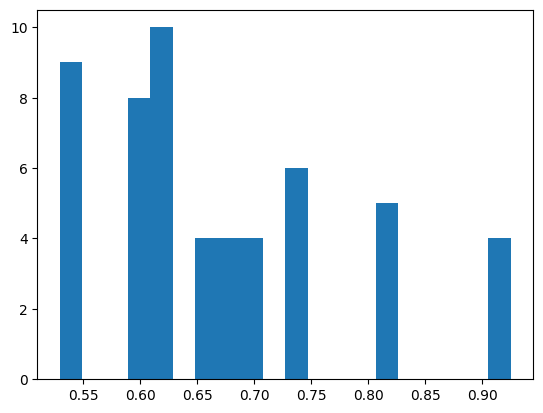

In [ ]:
# @title
import matplotlib.pyplot as plt
num_epochs = 30  # Adjust based on early stopping
train_losses, val_losses = [], []
train_accs, val_accs = [], []
max_error = 0
errors = []
neutral = 0
total_samples = 0
model.load_state_dict(torch.load('best_modelLowError.pt'))
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss, correct_train, total_train = 0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)

        # Add these checks
        if torch.isnan(outputs).any():
            print("NaN in model outputs!")
            break
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()

   # Validation phase
    model.eval()

    epoch_val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            total_samples += batch_y.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()

            if (epoch == num_epochs -1):
              total_samples += batch_y.size(0)
              for i in range(len(predicted)):
                if (outputs.data[i][1] < 0.98) and (outputs.data[i][0] < 0.98):
                  neutral += 1

              for i in range(len(predicted)):
                if predicted[i] != batch_y[i]:
                  errors.append(outputs.data[i][0 if batch_y[i] == 1 else 1].cpu().numpy())
                  if outputs.data[i][0 if batch_y[i] == 1 else 1] < 0.5: #model is wrong
                    print(f"Weird things are happening: {outputs.data[i][0 if batch_y[i] == 1 else 1]}, {outputs.data[i][1 if batch_y[i] == 1 else 0]}")
    #Compute epoch metrics
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)
    train_acc = correct_train / total_train
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if epoch % 2 == 0:
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")
        print("----------------------------------")
print(f"Max Error: {max_error}")
plt.hist(errors, bins = 20)
plt.show()

90% Cutoff: 0.8181471228599548
95% Cutoff: 0.9250420928001404
99% Cutoff: 0.9250420928001404
7812
84


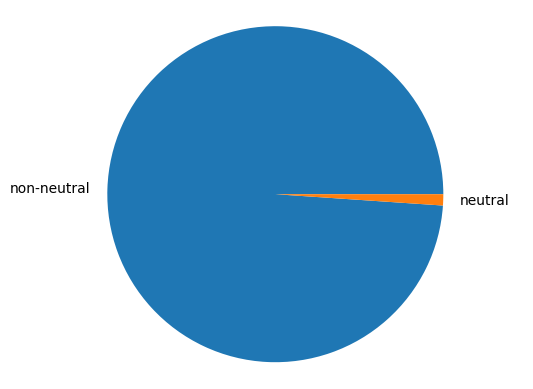

In [ ]:
errors.sort()
print(f"90% Cutoff: {errors[int(len(errors)*0.9)]}")
print(f"95% Cutoff: {errors[int(len(errors)*0.95)]}")
print(f"99% Cutoff: {errors[int(len(errors)*0.98)]}")
error_total = len(errors)
print(f"{total_samples}")
print(f"{neutral}")
labels = ["non-neutral", "neutral"]
sizes = [total_samples - neutral, neutral]
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()
#torch.save(model.state_dict(), 'best_modelLowError2.pt')

In [ ]:
!pip install optuna

In [ ]:
#Try using optuna to optimize: Channel count, channel filter count, dropout probability, kernel length, linear layer depth, linear layer size
#Not trying different pooling sizes, can attempt later
batch_size = 24

import os
import torch
import optuna
from optuna.trial import TrialState



class Net(nn.Module):
    def __init__(self, trial, parallel_channels,
                 kernel_size,
                 num_conv_layers, output_channels,
                 drop, linear_layers,
                 linear_depth, num_classes,
                 input_channels):
        """Parameters:
            - trial (optuna.trial._trial.Trial): Optuna trial
            - kernel_size (list):                Size of the kernels
            - parallel_channels (int):           Number of parallel channels
            - num_conv_layers (int):             Number of convolutional layers, same for all parallel channels
            - output_channels (list):            Output channels for each convolutional layer
            - drop (int):    Dropout probability for convolutional layers
            - linear_layers (int):               Number of linear layers, needs to start at 0 actually, not 1
            - linear_depth (list):               Depth of each linear layer
            - num_classes (int):                 Number of output classes
        """
        super(Net, self).__init__()                                                     # Initialize parent class
        in_size = 80
        self.parallels = nn.ModuleList()                                                     # List with the parallel channels
        j = 0
        self.out_sizes = []
        self.norms = None
        for i in range(parallel_channels):
          # Define the convolutional layers for each parallel channel
          self.convs = nn.ModuleList([nn.Conv1d(input_channels, output_channels[j], kernel_size=kernel_size[j], padding='same')])  # List with the Conv layers
          out_size = in_size - kernel_size[j] + 1                                            # Size of the output kernel
          j += 1
          out_size = int(out_size / 2)                                                      # Size after pooling
          for k in range(1, num_conv_layers):
              self.convs.append(nn.Conv1d(in_channels=output_channels[j-1], out_channels=output_channels[j], kernel_size=kernel_size[j]))
              out_size = out_size - kernel_size[j] + 1                                       # Size of the output kernel
              out_size = int(out_size/2)                                               # Size after pooling
              j += 1
          self.out_sizes.append(out_size)
          self.parallels.append(self.convs)                                               #Add whole parallel channel to parallels list
        self.conv_drop = nn.Dropout1d(p=drop)                                             #convolutional dropout

        self.drop = drop


        # Dynamically calculate FC input dimension in forward pass
        self.fc_input_dim = None # Initialize to None

        self.layers = []
        self.linear_layers = linear_layers # Store linear_layers
        self.linear_depth = linear_depth # Store linear_depth
        self.num_classes = num_classes # Store num_classes

    def forward(self, x):
        outputs = []
        for j, parallel_i in enumerate(self.parallels):
            branch_output = x
            for i, conv_i in enumerate(self.parallels[j]):
                branch_output = conv_i(branch_output)
                #self.norms = nn.BatchNorm1d(branch_output.shape[-2])
                branch_output = F.relu(F.max_pool1d(self.conv_drop((branch_output)), 2))
            outputs.append(branch_output.flatten(1))

        total_out_features = sum(out.shape[1] for out in outputs)  # Calculate total output features
        if self.fc_input_dim is None or self.fc_input_dim != total_out_features:
            self.fc_input_dim = total_out_features
            # Re-create fully connected layers based on calculated input dimension
            self.layers = []
            out_feature = self.fc_input_dim
            for i in range(self.linear_layers):
                self.layers.append(nn.Linear(out_feature, self.linear_depth[i]))
                self.layers.append(nn.Dropout(p = self.drop))
                out_feature = self.linear_depth[i]
            self.layers.append(nn.Linear(out_feature, self.num_classes))
            self.fc = nn.Sequential(*self.layers).to(device)



        # Concatenate outputs from all branches along the channel dimension
        x = torch.cat(outputs, dim = 1)
        x = F.relu(self.fc(x))                               #pass through all layers
        return F.softmax(x, dim=-1)


def train(model, optimizer):
    """Trains the model.

    Parameters:
        - network (__main__.Net):              The CNN
        - optimizer (torch.optim.<optimizer>): The optimizer for the CNN
    """
    Epoch_Count = 0
    criterion = nn.CrossEntropyLoss()
    model.train()  # Set the module in training mode (only affects certain modules)
    for batch_i, (data, target) in enumerate(train_loader):  # For each batch

        if data.shape[0] != batch_size:
            break

        optimizer.zero_grad()                                 # Clear gradients
        output = model(data.to(device))                     # Forward propagation
        loss = criterion(output, target.to(device))          # Compute loss (negative log likelihood: −log(y))
        loss.backward()                                       # Compute gradients
        optimizer.step()                                      # Update weights
    Epoch_Count += 1
def test(model):
    """Tests the model.

    Parameters:
        - network (__main__.Net): The CNN

    Returns:
        - accuracy_test (torch.Tensor): The test accuracy
    """

    model.eval()        # Set the module in evaluation mode (only affects certain modules)
    total_val = 1
    correct_val = 0
    with torch.no_grad():  # Disable gradient calculation (when you are sure that you will not call Tensor.backward())
      for batch, (data, target) in enumerate(val_loader):  # For each batch
        if data.shape[0] != batch_size:
          break
        output = model(data.to(device))               # Forward propagation
        argmax = []
        for element in output:
          if element[0] > element[1]: argmax.append(0)
          else: argmax.append(1)
        outputs = torch.tensor(argmax).to(device)
        predicted = outputs
        total_val += target.size(0)
        correct_val += (predicted == target.to(device)).sum().item()
    accuracy_test = correct_val / total_val
    return accuracy_test

def objective(trial):
    """Objective function to be optimized by Optuna.

    Hyperparameters chosen to be optimized: optimizer, learning rate,
    dropout values, number of convolutional layers, number of filters of
    convolutional layers, number of neurons of fully connected layers.

    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
    """

    # Define range of values to be tested for the hyperparameters
    # first layer input length = 80
    # second layer input length = 32
    # third layer input length = 8

    # parallel_channels = trial.suggest_int("parallel_channels", 1, 6)  # Number of parallel channels
    # num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)  # Number of convolutional layers
    # kernel_size = [0] * parallel_channels * num_conv_layers
    # output_channels = [0] * parallel_channels * num_conv_layers
    # for i in range(parallel_channels * num_conv_layers):
    #   if (i + 1) % num_conv_layers == 0:
    #     kernel_size[i] = trial.suggest_int("kernel_size_"+str(i), 2, 8)
    #   else:
    #     kernel_size[i] = trial.suggest_int("kernel_size_"+str(i), 3, 16)
    # for i in range(num_conv_layers * parallel_channels):
    #   output_channels[i] = trial.suggest_int("output_channels_"+str(i), 4, 32, 4)
    # drop = trial.suggest_float("drop", 0.2, 0.5)  # Dropout probability
    # linear_layers = trial.suggest_int("linear_layers", 0, 3)  # Number of linear layers
    # linear_depth = [int(trial.suggest_discrete_uniform("linear_depth_"+str(i), 10, 400, 10))
    #                 for i in range(linear_layers)]  # Depth of each linear layer


    parallel_channels =  6
    num_conv_layers =  2
    #kernel_size = [11, 3, 9, 2, 13, 7, 5, 3, 12, 6, 15, 8]
    #output_channels = [12, 32, 24, 12, 8, 8, 20, 4, 16, 8, 12, 4]
    kernel_size = [0] * parallel_channels * num_conv_layers
    output_channels = [0] * parallel_channels * num_conv_layers
    for i in range(parallel_channels * num_conv_layers):
      if (i + 1) % num_conv_layers == 0:
        kernel_size[i] = trial.suggest_int("kernel_size_"+str(i), 2, 8)
      else:
        kernel_size[i] = trial.suggest_int("kernel_size_"+str(i), 3, 16)
    for i in range(num_conv_layers * parallel_channels):
      output_channels[i] = trial.suggest_int("output_channels_"+str(i), 4, 32, 4)
    drop = 0.2915637951496211
    linear_layers = 0
    linear_depth = 1
    lr =  0.008900505464977875
    num_classes = 2

    # Generate the model
    model = Net(trial, parallel_channels,
                 kernel_size,
                 num_conv_layers, output_channels,
                 drop, linear_layers,
                 linear_depth, num_classes, 16).to(device)

    # Generate the optimizers
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])  # Optimizers
    #lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)                                 # Learning rates
    #optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    lr =  0.008900505464977875
    optimizer = torch.optim.Adam(model.parameters(), lr= lr)
    num_epochs = 42

    # Training of the model
    max_acc = 0
    for epoch in range(num_epochs):

        train(model, optimizer)  # Train the model
        accuracy = test(model)   # Evaluate the model
        if accuracy > max_acc:
          max_acc = accuracy
          torch.save(model.state_dict(), 'best_model.pt')

        # For pruning (stops trial early if not promising)
        trial.report(accuracy, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


if __name__ == '__main__':

    # -------------------------------------------------------------------------
    # Optimization study for a PyTorch CNN with Optuna
    # -------------------------------------------------------------------------

    # Use cuda if available for faster computations
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Parameters ----------------------------------------------------------

    batch_size_train = 24               # Batch size for training data
    batch_size_test = 24               # Batch size for testing data
    number_of_trials = 500                # Number of Optuna trials
    limit_obs = False                      # Limit number of observations for faster computation

    # *** Note: For more accurate results, do not limit the observations.
    #           If not limited, however, it might take a very long time to run.
    #           Another option is to limit the number of epochs. ***

    if limit_obs:  # Limit number of observations
        number_of_train_examples = 500 * batch_size_train  # Max train observations
        number_of_test_examples = 5 * batch_size_test      # Max test observations
    else:
        number_of_train_examples = 60000                   # Max train observations
        number_of_test_examples = 10000                    # Max test observations
    # -------------------------------------------------------------------------

    # Make runs repeatable
    random_seed = 1
    torch.backends.cudnn.enabled = False  # Disable cuDNN use of nondeterministic algorithms
    torch.manual_seed(random_seed)

    # Create an Optuna study to maximize test accuracy
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=number_of_trials)

    # -------------------------------------------------------------------------
    # Results
    # -------------------------------------------------------------------------

    # Find number of pruned and completed trials
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    # Display the study statistics
    print("\nStudy statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    trial = study.best_trial
    print("Best trial:")
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Save results to csv file
    df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
    df = df.loc[df['state'] == 'COMPLETE']        # Keep only results that did not prune
    df = df.drop('state', axis=1)                 # Exclude state column
    df = df.sort_values('value')                  # Sort based on accuracy
    df.to_csv('optuna_results.csv', index=False)  # Save to csv file

    # Display results in a dataframe
    print("\nOverall Results (ordered by accuracy):\n {}".format(df))

    # Find the most important hyperparameters
    most_important_parameters = optuna.importance.get_param_importances(study, target=None)

    # Display the most important hyperparameters
    print('\nMost important hyperparameters:')
    for key, value in most_important_parameters.items():
        print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))

[I 2025-04-03 07:04:54,986] A new study created in memory with name: no-name-0641e689-f7f8-4f18-8648-f212790c50b3
<ipython-input-17-b6b9e023db7f>:190: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  output_channels[i] = trial.suggest_int("output_channels_"+str(i), 4, 32, 4)
[I 2025-04-03 07:05:14,678] Trial 0 finished with value: 0.7759336099585062 and parameters: {'kernel_size_0': 10, 'kernel_size_1': 3, 'kernel_size_2': 8, 'kernel_size_3': 5, 'kernel_size_4': 9, 'kernel_size_5': 6, 'kernel_size_6': 15, 'kernel_size_7': 6, 'kernel_size_8': 12, 'kernel_size_9': 7, 'kernel_size_10': 15, 'kernel_size_11': 5, 'output_channels_0': 4, 'output_channels_1': 20, 'output_channels_2': 8, 'output_channels_3': 28, 'output_channels_4': 20, 'output_channels_5': 12, 'output_channels_6': 12, 'output_channels_7': 16, 'output_channels_8': 24, 'output_channels_9': 12, 'output_channels_10': 20, 'output_channels_11': 28}. Best is 

In [ ]:
#test new model
# @title
#Best acc = 83.4% (42 epochs)
parallel_channels =  6
num_conv_layers =  2
kernel_size = [11, 3, 9, 2, 13, 7, 5, 3, 12, 6, 15, 8]
output_channels = [12, 32, 24, 12, 8, 8, 20, 4, 16, 8, 12, 4]
drop = 0.2915637951496211
linear_layers = 0
lr =  0.008900505464977875
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 42  # Adjust based on early stopping
# kernel_size_0': 4, 'kernel_size_1': 7, 'kernel_size_2': 6,
# 'kernel_size_3': 5, 'kernel_size_4': 6, 'kernel_size_5': 4,
# 'kernel_size_6': 10, 'kernel_size_7': 6, 'kernel_size_8': 13,
# 'kernel_size_9': 4, 'kernel_size_10': 15, 'kernel_size_11': 7,
# 'output_channels_0': 8, 'output_channels_1': 16,
# 'output_channels_2': 4, 'output_channels_3': 4,
# 'output_channels_4': 4, 'output_channels_5': 28,
# 'output_channels_6': 28, 'output_channels_7': 4,
# 'output_channels_8': 8, 'output_channels_9': 8,
# 'output_channels_10': 8, 'output_channels_11': 24

class TestNet(nn.Module):
  def __init__(self, input_channels, input_length, num_classes, drop):
        super(TestNet, self).__init__()
        self.input_channels = input_channels
        self.input_length = input_length
        self.num_classes = num_classes


        self.branch1 = nn.Sequential(
            nn.Conv1d(input_channels, 12, kernel_size=4, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.MaxPool1d(2),
            nn.Conv1d(12, 32, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
        )


        self.branch2 = nn.Sequential(
            nn.Conv1d(input_channels, 24, kernel_size=6, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.MaxPool1d(2),
            nn.Conv1d(24, 12, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.branch3 = nn.Sequential(
            nn.Conv1d(input_channels, 8, kernel_size=6, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 8, kernel_size=4, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.branch5 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=13, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 8, kernel_size=4, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.branch4 = nn.Sequential(
            nn.Conv1d(input_channels, 20, kernel_size=10, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.MaxPool1d(2),
            nn.Conv1d(20, 4, kernel_size=6, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.branch6 = nn.Sequential(
            nn.Conv1d(input_channels, 12, kernel_size=15, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.MaxPool1d(2),
            nn.Conv1d(12, 4, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.Dropout(drop),
        )


        with torch.no_grad():
            example_input = torch.randn(1, input_channels, input_length)
            out1 = self.branch1(example_input)
            out2 = self.branch2(example_input)
            out3 = self.branch3(example_input)
            out4 = self.branch4(example_input)
            out5 = self.branch5(example_input)
            out6 = self.branch6(example_input)
            self.fc_input_dim = out1.numel() + out2.numel() + out3.numel() + out4.numel() + out5.numel() + out6.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, num_classes),
            nn.ReLU(),
        )

  def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out5 = self.branch5(x)
        out6 = self.branch6(x)
        combined = torch.cat([out1.flatten(1), out2.flatten(1), out3.flatten(1), out4.flatten(1), out5.flatten(1), out6.flatten(1)], dim=1)
        return F.softmax(self.fc(combined), dim = -1)

model = TestNet(16, 80, 2, 0.2915637951496211).to(device)
model.load_state_dict(torch.load('best_model.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr= 0.008900505464977875)
model.eval()

parallel_channels =  6
num_conv_layers =  2
kernel_size = [11, 3, 9, 2, 13, 7, 5, 3, 12, 6, 15, 8]
output_channels = [12, 32, 24, 12, 8, 8, 20, 4, 16, 8, 12, 4]
drop = 0.2915637951496211
linear_layers = 0
lr =  0.008900505464977875
optimizer = torch.optim.Adam(model.parameters(), lr= lr)
num_epochs = 42
train_losses, val_losses = [], []
train_accs, val_accs = [], []


for epoch in range(30):
    # Training phase
    # model.train()
    # epoch_train_loss, correct_train, total_train = 0, 0, 0
    # for batch, (data, targets) in enumerate(train_loader):
    #     data, targets = data.to(device), targets.to(device)
    #     outputs = model(data)

    #     # Add these checks
    #     if torch.isnan(outputs).any():
    #         print("NaN in model outputs!")
    #         break
    #     loss = criterion(outputs, targets)

    #     optimizer.zero_grad()
    #     loss.backward()
    #     optimizer.step()

    #     # Track metrics
    #     epoch_train_loss += loss.item()
    #     _, predicted = torch.max(outputs.data, 1)
    #     total_train += targets.size(0)
    #     correct_train += (predicted == targets).sum().item()

    # Validation phase
    model.eval()
    epoch_val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for batch, (data, targets) in enumerate(val_loader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    # Compute epoch metrics
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)
    train_acc = correct_train / total_train
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")
    print("----------------------------------")


RuntimeError: Error(s) in loading state_dict for TestNet:
	Missing key(s) in state_dict: "branch1.0.weight", "branch1.0.bias", "branch1.4.weight", "branch1.4.bias", "branch2.0.weight", "branch2.0.bias", "branch2.4.weight", "branch2.4.bias", "branch3.0.weight", "branch3.0.bias", "branch3.4.weight", "branch3.4.bias", "branch5.0.weight", "branch5.0.bias", "branch5.4.weight", "branch5.4.bias", "branch4.0.weight", "branch4.0.bias", "branch4.4.weight", "branch4.4.bias", "branch6.0.weight", "branch6.0.bias", "branch6.4.weight", "branch6.4.bias". 
	Unexpected key(s) in state_dict: "parallels.0.0.weight", "parallels.0.0.bias", "parallels.0.1.weight", "parallels.0.1.bias", "parallels.1.0.weight", "parallels.1.0.bias", "parallels.1.1.weight", "parallels.1.1.bias", "parallels.2.0.weight", "parallels.2.0.bias", "parallels.2.1.weight", "parallels.2.1.bias", "parallels.3.0.weight", "parallels.3.0.bias", "parallels.3.1.weight", "parallels.3.1.bias", "parallels.4.0.weight", "parallels.4.0.bias", "parallels.4.1.weight", "parallels.4.1.bias", "parallels.5.0.weight", "parallels.5.0.bias", "parallels.5.1.weight", "parallels.5.1.bias", "convs.0.weight", "convs.0.bias", "convs.1.weight", "convs.1.bias". 
	size mismatch for fc.0.weight: copying a param with shape torch.Size([2, 1744]) from checkpoint, the shape in current model is torch.Size([2, 2720]).